# 트리의 앙상블  
---

## 정형 데이터와 비정형 데이터  
---

- 정형 데이터:csv,엑셀,데이터베이스  
- 비정형 데이터:사진,텍스트,음악  

지금까지 배운 머신러닝 알고리즘은 정형 데이터에 잘 맞고, 그 중에 가장 뛰어난 성과를 내는 알고리즘이 **앙상블 학습**  
이 알고리즘은 대부분 결정 트리를 기반으로 만들어짐  
비정형은 신경망 알고리즘을 사용

## 랜덤포레스트  
---

결정 트리를 랜덤하게 만들어 숲을 만든다  
랜덤하게 만드는 방식은 부스트랩을 사용  
각 노드를 분할할 때 전체 특성 중에서 일부 특성을 무작위로 고른 다음 이 중에서 최선의 분할을 찾음  
RandomForestClassifier은 제곱근만큼 사용, RandomForestRegressor는 전체 특성을 사용

분류일 때는 각 트리의 클래스별 확률을 평균하여 가장 높은 확률을 가진 클래스를 예측  
회귀일 때는 단순히 각 트리의 예측을 평균

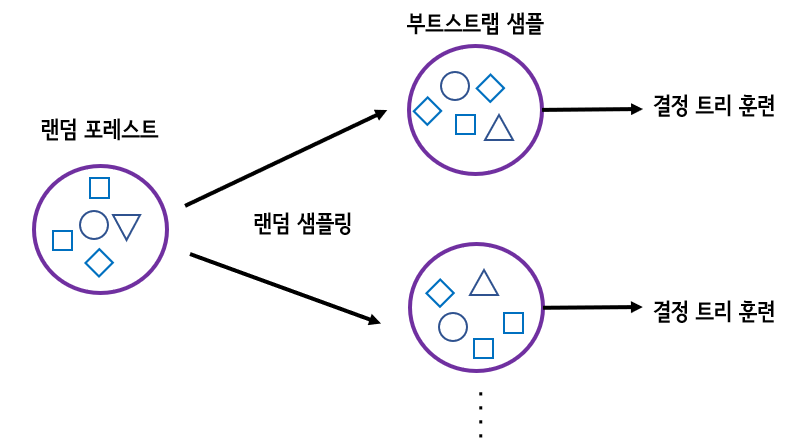

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

wine = pd.read_csv('https://bit.ly/wine_csv_data')

data = wine[['alcohol', 'sugar', 'pH']].to_numpy()
target = wine['class'].to_numpy()

train_input, test_input, train_target, test_target = train_test_split(data, target, test_size=0.2, random_state=42)

In [2]:
from sklearn.model_selection import cross_validate
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_jobs=-1, random_state=42)
scores = cross_validate(rf, train_input, train_target, return_train_score=True, n_jobs=-1)

print(np.mean(scores['train_score']), np.mean(scores['test_score']))

0.9973541965122431 0.8905151032797809


In [3]:
rf.fit(train_input, train_target)
print(rf.feature_importances_)

[0.23167441 0.50039841 0.26792718]


앞에서 했던 중요도는 [0.12345626,0.86862934,0.0079144]였다  
당도는 떨어지고 도수와 pH가 상승했는데 특성의 일부를 랜덤하게 선택하여 훈련하기 때문  
과도하게 집중하지 않고 좀 더 많은 특성이 훈련할 기회를 주는데, 이는 과대적합을 줄이고 일반화 성능을 높임

 RandomForestClassifier를 하면 부스트랩 샘플에 포함되지 않는 샘플을 out og bag이라 하고 이는 검증 세트로 사용가능

In [4]:
rf = RandomForestClassifier(oob_score=True, n_jobs=-1, random_state=42)

rf.fit(train_input, train_target)
print(rf.oob_score_)

0.8934000384837406


## 엑스트라트리  
---

부스트랩을 사용하지 않고 전체 훈련세트를 사용  
대신 노드를 분할할 때 무작위로

In [5]:
from sklearn.ensemble import ExtraTreesClassifier

et = ExtraTreesClassifier(n_jobs=-1, random_state=42)
scores = cross_validate(et, train_input, train_target, return_train_score=True, n_jobs=-1)

print(np.mean(scores['train_score']), np.mean(scores['test_score']))

0.9974503966084433 0.8887848893166506


In [6]:
et.fit(train_input, train_target)
print(et.feature_importances_)

[0.20183568 0.52242907 0.27573525]


## 그레이디언트 부스팅  
---

깊이가 얕은 결정 트리를 사용하여 이전 트리의 오차를 보완하는 방식으로 앙상블 하는 방법  
깊이가 얕아서 과대적합에 강하고 일반적으로 높은 일반화 성능을 기대할 수 있음

In [7]:
from sklearn.ensemble import GradientBoostingClassifier

gb = GradientBoostingClassifier(random_state=42)
scores = cross_validate(gb, train_input, train_target, return_train_score=True, n_jobs=-1)

print(np.mean(scores['train_score']), np.mean(scores['test_score']))

0.8881086892152563 0.8720430147331015


In [8]:
gb = GradientBoostingClassifier(n_estimators=500, learning_rate=0.2, random_state=42)
scores = cross_validate(gb, train_input, train_target, return_train_score=True, n_jobs=-1)

print(np.mean(scores['train_score']), np.mean(scores['test_score']))

0.9464595437171814 0.8780082549788999


In [9]:
gb.fit(train_input, train_target)
print(gb.feature_importances_)

[0.15872278 0.68010884 0.16116839]


훈련 세트의 비율을 정하는 subsample은 기본이 1로 전체를 사용  
1보다 작으면 일부를 사용  
이렇게 하면 미니배치 경사 하강법이랑 비슷

## 히스토그램 기반 그레이디언트 부스팅  
---

입력 특성을 256으로 나눠서 노드를 분할할 때 최적의 분할을 매우 빠르게 찾을 수 있음  
256개의 구간 중에서 하나를 떼어 놓고 누락된 값을 위해서 사용하여 누락된 특성이 있어도 따로 전처리 필요 없음 

In [11]:
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingClassifier

hgb = HistGradientBoostingClassifier(random_state=42)
scores = cross_validate(hgb, train_input, train_target, return_train_score=True, n_jobs=-1)

print(np.mean(scores['train_score']), np.mean(scores['test_score']))

0.9321723946453317 0.8801241948619236


In [12]:
from sklearn.inspection import permutation_importance

hgb.fit(train_input, train_target)
result = permutation_importance(hgb, train_input, train_target, n_repeats=10,
                                random_state=42, n_jobs=-1)
print(result.importances_mean)

[0.08876275 0.23438522 0.08027708]


In [13]:
result = permutation_importance(hgb, test_input, test_target, n_repeats=10,
                                random_state=42, n_jobs=-1)
print(result.importances_mean)

[0.05969231 0.20238462 0.049     ]


In [14]:
hgb.score(test_input, test_target)

0.8723076923076923

앙상블 학습이 단일 결정 트리(86%)보다는 좋은 결과가 나옴

사이킷런 말고도 그레이디언트 부스팅을 구현한 라이브러리가 있음  
대표가 XGBoost, LightGBM

### XGBoost  
---

In [ ]:
#  pip install xgboost

In [18]:
from xgboost import XGBClassifier

xgb = XGBClassifier(tree_method='hist', random_state=42)
scores = cross_validate(xgb, train_input, train_target, return_train_score=True, n_jobs=-1)

print(np.mean(scores['train_score']), np.mean(scores['test_score']))

0.9555033709953124 0.8799326275264677


### LightGBM  
---

In [16]:
from lightgbm import LGBMClassifier

lgb = LGBMClassifier(random_state=42)
scores = cross_validate(lgb, train_input, train_target, return_train_score=True, n_jobs=-1)

print(np.mean(scores['train_score']), np.mean(scores['test_score']))

0.935828414851749 0.8801251203079884
